In [1]:
"""
Created November 2023

@author: Annika Deutsch
@date: 11/2023
@title: roc_curves.ipynb
@description: For a subset of pulsars with known binary companions, calculate roc curves to determine the ideal search radius 
to be performing the query in
"""

'\nCreated November 2023\n\n@author: Annika Deutsch\n@date: 11/2023\n@title: roc_curves.ipynb\n@description: For a subset of pulsars with known binary companions, calculate roc curves to determine the ideal search radius \nto be performing the query in\n'

## Imports

In [1]:
import astropy
import astropy.units as u
import astroquery
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from astropy.time import Time 
import os
from astropy.io.votable import parse_single_table
from astropy.time import Time
import pytest
from astropy.table import Table, vstack
import csv
import pandas as pd
from astropy.io.votable import from_table, writeto
from IPython.display import display
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap

In [5]:
# define colors to be used across presentation:
lime = '#e4ffba'
lemon = '#fef6c7'
bora = '#b186ce'
sky = '#b2eaf0'
strawberry = '#ff9cff'
coral = '#feb5a4'

In [14]:
#Set Matplotlib style parameters for dark background
# rcParams['figure.facecolor'] = 'black'  # Dark background color
# rcParams['axes.facecolor'] = 'black'
# rcParams['axes.edgecolor'] = strawberry
# rcParams['axes.labelcolor'] = strawberry
# rcParams['xtick.color'] = strawberry
# rcParams['ytick.color'] = strawberry
# rcParams['text.color'] = strawberry
# rcParams['axes.titlecolor'] = strawberry

## Load in Table of Matches

In [3]:
npz = np.load('/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/cross-matches/matches_10arcsec_11-1_sourceseps.npz', allow_pickle=True)
table = Table(npz['arr_0'])

In [4]:
condition = Angle(table['source_seps'], unit=u.deg).arcsec <= 1.3
table[condition]

Companion Pulsar,Pulsar RA,Pulsar DEC,Binary,Binary Companion,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,source_seps,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist
str12,str16,str16,str6,str16,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,object,float64,float64,float64,float64,bool,bool,int16,bool,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,object,float64
J0024-7204aa,00

In [5]:
# add a 'label' column to this table
table.add_column(np.empty(len(table['Companion Pulsar']), dtype='str_'), name='Label', index=1)

## Load in Tables of "Known" Matches (sets with which to determine true vs/ false)

In [6]:
# jennings paper
jennings_psrs = ['J0337+1715', 'J0437-4715', 'J1012+5307', 'J1023+0038', 'J1227-4853', 'J1302-6350', 'J1417-4402', 'J1431-4715', 
                   'J1723-2837', 'J2032+4127', 'J2129-0429', 'J2339-0533', 'J0045-7319', 'J0348+0432', 'J1024-0719', 'J1048+2339',
                   'J1311-3430', 'J1628-3205', 'J1810+1744', 'J1816+4510', 'J1957+2516', 'J2215+5135']
jennings_gmags = [18.08, 20.41, 19.63, 16.27, 18.08, 9.63, 15.79, 17.75, 15.55, 11.36, 16.84, 18.97, 16.22, 20.64, 19.18, 19.65, 20.53,
                  19.52, 20.08, 18.22, 20.30, 19.24]

jennings = Table([jennings_psrs, jennings_gmags], names=('Companion Pulsar', 'phot_bp_mean_mag'))

#koljonen paper
koljonen_psrs = ['J0212+5320', 'J1023+0038', 'J1036-4353', 'J1048+2339', 'J1227-4853', 'J1306-40', 'J1431-4715', 'J1622-0315',
                 'J1628-3205', 'J1723-2837', 'J1803-6707', 'J1816+4510', 'J1908+2105', 'J1910-5320', 'J1957+2516', 'J2039-5618',
                 'J2129-0429', 'J2215+5135', 'J2339-0533', 'J0407.7-5702', 'J0427.9-6704', 'J0523-2529', 'J0838.8-2829', 
                 'J0846.0+2820', 'J0935.3+0901', 'J0940.3-7610', 'J0954.8-3948', 'J1417.5-4402', 'J1544-1128', 'J2333.1-5527',
                 'J1311-3430', 'J1555-2908', 'J1653-0158', 'J1731-1847', 'J1810+1744', 'J1928+1245', 'J1959+2048', 'J2055+3829',
                 'J0336.0+7505', 'J0935.3+0901', 'J1406+1222']

koljonen_sourceids = [455282205716288384, 3831382647922429952, 5367876720979404288, 3990037124929068032, 6128369984328414336, 6140785016794586752,
            6098156298150016768, 4358428942492430336, 6025344817107454464, 4059795674516044800, 6436867623955512064, 2115337192179377792,
            4519819661567533696, 6644467032871428992, 1834595731470345472, 6469722508861870080, 2672030065446134656, 2001168543319218048, 
            2440660623886405504, 4682464743003293312, 4656677385699742208, 2957031626919939456, 5645504747023158400, 705098703608575744,
            588191888537402112, 5203822684102798592, 5419965878188457984, 6096705840454620800, 6268529198286308224, 6496325574947304448,
            6179115508262195200, 6041127310076589056, 4379227476242700928, 4121864828231575168, 4526229058440076288, 4316237348443952128,
            1823773960079216896, 1872588462410154240, 544927450310303104, 588191888537402112, 1226507282368609152]

koljonen = Table([koljonen_psrs, koljonen_sourceids], names=['Companion Pulsar', 'source_id'])

# ATNF Binaries -- the problem with this is the same as it would be for jennings: there's gna be psr reduplication
atnf = Table([table[table['Binary Companion'] != '*']['Companion Pulsar']], names=['Companion Pulsar'])

## Generate the ROC curve

In [12]:
def roc(data, positives, comparison_param='source_id', max_searc_rad=10.0):
    # give each pulsar in the main table a label of TP or FP
    for j in data:
        hit = False
        for k in positives:
            if j[comparison_param] == k[comparison_param]:
                #if abs(j['phot_bp_mean_mag'] - k['phot_bp_mean_mag']) <= 4.0:
                hit = True
        if hit:
            j['Label'] = 'T'
        else:
            j['Label'] = 'F'
    
    # create table of radii and probabilities
    radii = np.linspace(0.1, max_searc_rad, 100)
    p_d = np.zeros(len(radii))
    p_fa = np.zeros(len(radii))

    pos = len(positives[comparison_param])
    neg = len(data[comparison_param]) - pos

    # iterate through radii and calculate probabilities
    for i in range(len(radii)):
        cond = Angle(data['source_seps'], unit=u.deg).arcsec <= radii[i] # limit table to this radius
        temp_table = data[cond]

        ntrue = len(temp_table[temp_table['Label'] == 'T'])
        nfalse = len(temp_table[temp_table['Label'] == 'F'])
        
        p_d[i] = ntrue/pos
        p_fa[i] = nfalse/neg
    
    roc = Table([radii, p_d, p_fa], names=('Search Radii', 'Probability of Detection', 'Probability of False Alarm'))

    return roc

## Jennings Paper:

Text(0.5, 1.0, 'ROC Curve: Jennings Paper')

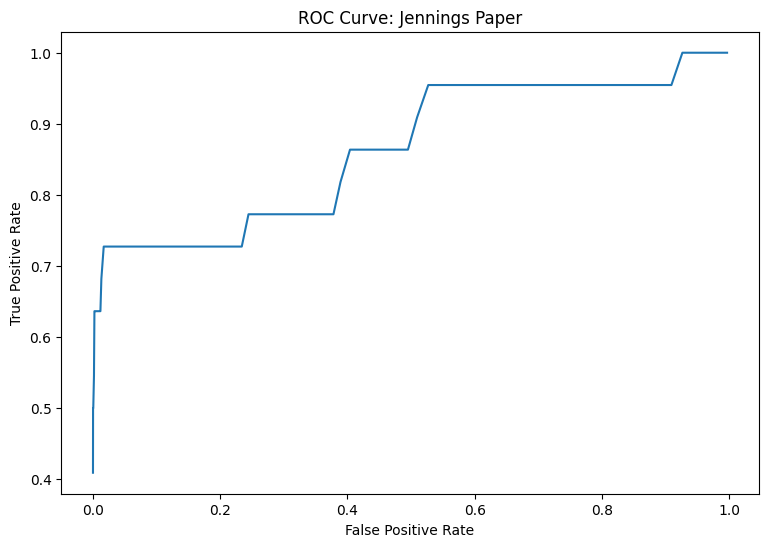

In [9]:
r1 = roc(table, jennings, comparison_param='Companion Pulsar', max_searc_rad=10.0)
plt.figure(1, figsize=(9,6))
plt.plot(r1['Probability of False Alarm'], r1['Probability of Detection'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Jennings Paper')

In [57]:
r1[r1['Probability of False Alarm'] <=0.05]

Search Radii,Probability of Detection,Probaility of False Alarm
float64,float64,float64
0.1,0.4090909090909091,0.00019470404984423675
0.2,0.5,0.0003245067497403946
0.30000000000000004,0.5,0.0006490134994807892
0.4,0.5454545454545454,0.0017523364485981308
0.5,0.6363636363636364,0.002466251298026999
0.6,0.6363636363636364,0.003245067497403946
0.7000000000000001,0.6363636363636364,0.004023883696780893
0.8,0.6363636363636364,0.005841121495327103
0.9,0.6363636363636364,0.00895638629283489


## Choose the r=1.3" radius from the Jennings ROC

In [155]:
roc_radius_table = table[Angle(table['source_seps'], unit=u.deg).arcsec <= 1.3]
roc_radius_table[abs(roc_radius_table['parallax']) >= 0.01]
table_jenningstrue = roc_radius_table[roc_radius_table['Label'] == 'T']

#table_jenningstrue.write('table_jenningstrue.txt', format='ascii')
table_jenningstrue

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Koljonen Paper:

Text(0.5, 1.0, 'ROC Curve: Koljonen Paper')

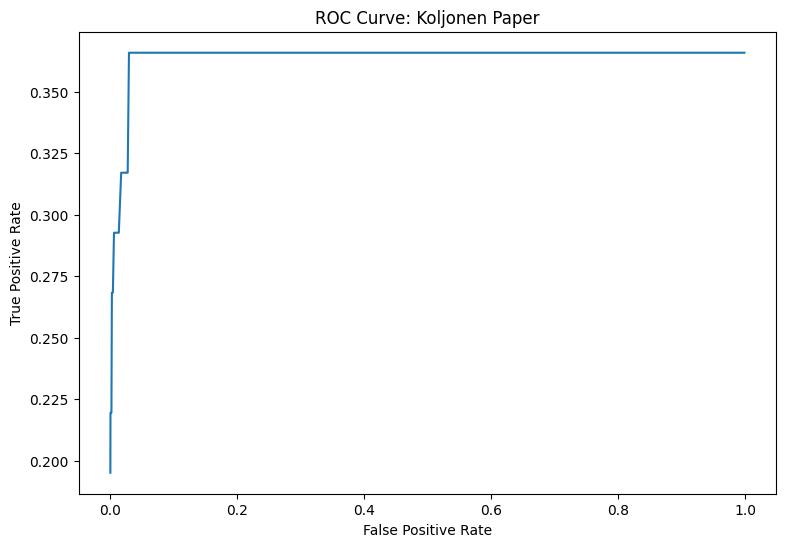

In [13]:
r2 = roc(table, koljonen, max_searc_rad=10.0, comparison_param='source_id')
plt.figure(2, figsize=(9,6))
plt.plot(r2['Probability of False Alarm'], r2['Probability of Detection'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Koljonen Paper')

In [68]:
r2[r2['Probability of False Alarm'] <= 0.05]

Search Radii,Probability of Detection,Probability of False Alarm
float64,float64,float64
0.1,0.1951219512195122,0.00025992592111248293
0.2,0.21951219512195122,0.0004548703619468451
0.30000000000000004,0.21951219512195122,0.0007797777633374489
0.4,0.21951219512195122,0.001949444408343622
0.5,0.2682926829268293,0.00266424069140295
0.6,0.2682926829268293,0.003444018454740399
0.7000000000000001,0.2682926829268293,0.004223796218077848
0.8,0.2926829268292683,0.0059782961855871074
0.9,0.2926829268292683,0.009097407238936903


## I now want to look at the pulsars that appear on the koljonen list, that are not on my own, and investigate why they do not show up

In [108]:
koljonen.add_column(np.empty(len(koljonen['Companion Pulsar']), dtype='str_'), name='psr_present', index=2)

In [117]:
table[table['Companion Pulsar'] == 'J1311-3430']

Companion Pulsar,Label,Pulsar RA,Pulsar DEC,Binary,Binary Companion,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,source_seps,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist
str12,str1,str16,str16,str6,str16,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,object,float64,float64,float64,float64,bool,bool,int16,bool,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,object,float64


In [109]:
'''
1. add a new column, psr_present to koljonen
2. For each element in koljonen, go through my list and check if that element is present
    - if yes, label yes in psr_present column
    - if no, label no in psr_present column 
3. create a new table that is only the koljonen elements labeled no
'''

for k in koljonen:
    present = False
    for j in table:
        if k['Companion Pulsar'] == j['Companion Pulsar']:
            present = True
    if present:
        k['psr_present'] = 'y'
    else:
        k['psr_present'] = 'n'

koljonen_additional_psrs = koljonen[koljonen['psr_present'] == 'n']

In [113]:
print(koljonen_additional_psrs)
koljonen_additional_psrs.write('koljonen-additional-psrs.txt', format='ascii')

Companion Pulsar      source_id      psr_present
---------------- ------------------- -----------
      J0212+5320  455282205716288384           n
      J1036-4353 5367876720979404288           n
        J1306-40 6140785016794586752           n
      J1628-3205 6025344817107454464           n
      J1803-6707 6436867623955512064           n
      J1908+2105 4519819661567533696           n
      J1910-5320 6644467032871428992           n
      J1957+2516 1834595731470345472           n
      J2039-5618 6469722508861870080           n
      J2215+5135 2001168543319218048           n
             ...                 ...         ...
    J0954.8-3948 5419965878188457984           n
    J1417.5-4402 6096705840454620800           n
      J1544-1128 6268529198286308224           n
    J2333.1-5527 6496325574947304448           n
      J1311-3430 6179115508262195200           n
      J1555-2908 6041127310076589056           n
      J1810+1744 4526229058440076288           n
      J1928+1245 431

## ATNF Binaries

In [76]:
#atnf[atnf['Companion Pulsar'] == 'J0024-7204H']
table[table['Companion Pulsar'] == 'J0024-7204H']

Companion Pulsar,Label,Pulsar RA,Pulsar DEC,Binary,Binary Companion,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,source_seps,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist
str12,str1,str16,str16,str6,str16,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,object,float64,float64,float64,float64,bool,bool,int16,bool,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,object,float64
J002

Text(0.5, 1.0, 'ROC Curve: ATNF Binaries')

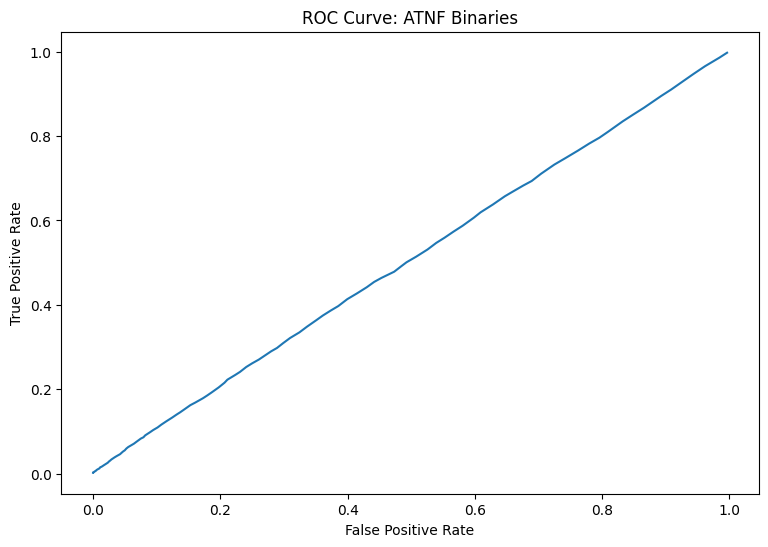

In [77]:
r3 = roc(table, atnf, comparison_param='Companion Pulsar', max_searc_rad=10.0)
plt.figure(3, figsize=(9,6))
plt.plot(r3['Probability of False Alarm'], r3['Probability of Detection'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: ATNF Binaries')

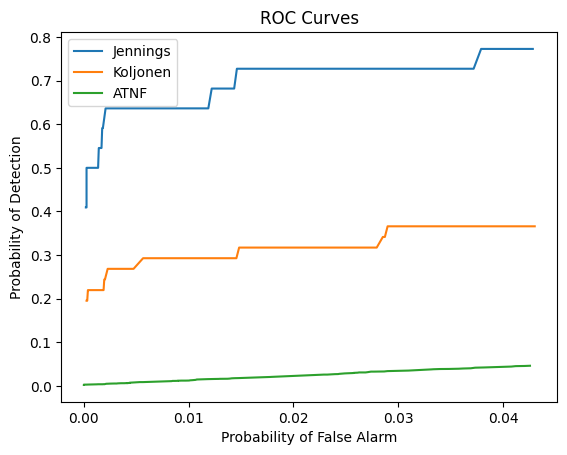

In [26]:
# plot all three on the same plot for funsies
plt.plot(r1['Probability of False Alarm'], r1['Probability of Detection'], label='Jennings')
plt.plot(r2['Probability of False Alarm'], r2['Probability of Detection'], label='Koljonen')
plt.plot(r3['Probability of False Alarm'], r3['Probability of Detection'], label='ATNF')
plt.xlabel('Probability of False Alarm')
plt.ylabel('Probability of Detection')
plt.title('ROC Curves')
plt.legend()